###Project Summary
<img src ='https://images.unsplash.com/photo-1548859047-1d15def63a14?ixlib=rb-1.2.1&ixid=MXwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHw%3D&auto=format&fit=crop&w=2700&q=80' width="800" height = "200">
######Ivy(Ruxin) Tong | November 15th, 2020 | Image courtesy of Ivan Olenkevich

####**Objective** : Address the Challenge of Evaluation and Prediction of American’s Mobility under Extreme Weather Events






####**Datasets** :  Weather_CBG_2019 | Social Distancing Metrics v2.1 
######***About the data***
- ***Dataset - Weather_CBG_2019 records daily weather parameters by census block group in the United States. There're 7 variables*** 

| Variable   | Description  | Unit | 
|-----------------  |---------------|------|
| geoid    | census block group ID |  | 
| precip  | daily precipitation | mm|
| rmax | maximum daily relative humidity | % |
| rmin | mminimum daily relative humidity | % |
| srad | surface downwelling solar radiation | W/m^2 |
| tmax | maximum daily temperature | degress F |
| tmin | minimum daily temperature | degress F |
| wind_speed | wind speed | mph|


- ***Dataset - Social Distancing Metrics v2.1 is a product of Safegraph which aggregately summarizes daily views of USA foot-traffic between census block groups. There're 23 variables. For this analysis, I mainly use :***

     *description based on Safegraph documentation*
  
| Variable   | Description  | Unit | 
|-----------------  |---------------|------|
| origin_census_block_group    | 12-digit FIPS code for the Census Block Group |  | 
| distance_traveled_from_home  | Median distance traveled from the geohash-7 of the home by the devices measured within the time period. All distance with 0 has been excluded. | meter |
| date_range_start  | Start time for measurement | YYYY-MM-DDTHH:mm:SS±hh:mm |
| date_range_end  | End time for measurement  | YYYY-MM-DDTHH:mm:SS±hh:mm|
| device_count | Total number of devices seen during the date range | count  |
| median_home_dwell_time  | Median dwell time at home during the time period |  min |  
| completely_home_device_count  | Number of device devices do not leave the house during the time period | count  |   





- ***Additional variables created for the analysis ***


| Variable   | Description  | Unit | 
|-----------------  |---------------|------|
| month   | month of each year | 1-12 | 
| day  | day of each year | 1-31 |
| weekday  | day of each week | 0-6 (0 for Mon) |
| ratio of not leaving | completely_home_device_count / device_count | ratio between 0 and 1 |

  
  
######***Acknowledgements*** : Social Distancing Metrics v2.1 is downloaded from Safegraph



####**Conclusion**:




####**Model and Result**:


####**Notebook** : There are two notebooks for this project:

Notebook1 details the data analysis for 2019 weather dataset, Jan social distancing dataset, and initial Jan modeling (mainly in Python) [Current]   

Notebook2 idetails 2019 whole year modeling (mainly in Spark)

#### Analysis
###### Step 0 : Install and Import libraries

In [0]:
%run ./Packages_setup

###### Step 1 : Data Preparation and Analysis for weather_cbg_2019
  - Connect AWS s3 bucket to Databricks and read the dataset

In [0]:
# # Secure access to S3 buckets using instance profiles
awsAccessKey = ""
# Encode the Secret Key to remove any "/" characters
secretKey = "".replace("/", "%2F")
awsBucketName = "weathercbg2019"
mountPoint = f"/mnt/weathercbg"

mountTarget = "s3a://{}:{}@{}".format(awsAccessKey, secretKey, awsBucketName)
dbutils.fs.mount(mountTarget, mountPoint)

In [0]:
dbutils.fs.ls("/mnt/weathercbg")

In [0]:
dbutils.fs.head("dbfs:/mnt/weathercbg/weather_cbg_2019.csv",1000)

In [0]:
# # #read weathercbgDF
weathercbgDF = (spark.read
  .option("delimiter", ",")
  .option("header", True)
  .option("inferSchema", True)
  .csv("/mnt/weathercbg/weather_cbg_2019.csv")
 )

- Transform and Explore the weather dataset

In [0]:
# #  Add three date-related variables
weathercbgDF = weathercbgDF.withColumn("month", F.month('date'))
weathercbgDF = weathercbgDF.withColumn("day", F.dayofmonth('date'))
weathercbgDF = weathercbgDF.withColumn("year", F.year('date'))
weathercbgDF.show(5)
# save to local folder so that we can access directly through databricks
weathercbgDF.write.format('com.databricks.spark.csv').save("/FileStore/weathercbgDF.csv",header = 'true',inferSchema = "true")

In [0]:
#   unmount s3
try:
  dbutils.fs.unmount(mountPoint)
except:
  print("{} already unmounted".format(mountPoint))

In [0]:
#decide to add a new variable after unmounting to s3
weathercbgDF = spark.read.format("csv").option("header", "true").option("inferSchema","true").load("/FileStore/weathercbgDF.csv")
# weathercbgDF =weathercbgDF.withColumn('day_of_week',dayofweek(weathercbgDF.date))

def spark_df_shape(self):
    return (self.count(),len(self.columns)) 
pyspark.sql.dataframe.DataFrame.shape = spark_df_shape


print("weather cbg 2019 dataset")
weathercbgDF.printSchema()
print("shape:")
print(weathercbgDF.shape())

weather cbg 2019 dataset
root
-- geoid: long (nullable = true)
-- date: string (nullable = true)
-- precip: double (nullable = true)
-- rmax: double (nullable = true)
-- rmin: double (nullable = true)
-- srad: double (nullable = true)
-- tmin: double (nullable = true)
-- tmax: double (nullable = true)
-- wind_speed: double (nullable = true)
-- month: integer (nullable = true)
-- day: integer (nullable = true)
-- year: integer (nullable = true)

shape:
(78654945, 12)

In [0]:
from pyspark.sql.functions import min, max

display(
  weathercbgDF.select(min("date"), max("date"))
)

min(date),max(date)
2019-01-01,2019-12-31


- Create summary table group by month and geoid & Basic visualization

In [0]:
#   create monthly summary table group by geoid, for visualization and faster operation
weather_cbg_month = (weathercbgDF.groupBy("geoid","month")
                            .agg(
                              mean("precip").alias("mean_precip"),
                              mean("rmax").alias("mean_rmax"),
                              mean("rmin").alias("mean_rmin"),
                              mean("srad").alias("mean_srad"),
                              mean("tmin").alias("mean_tmin"),
                              mean("tmax").alias("mean_tmax"),
                              mean("wind_speed").alias("mean_wind_speed"))
                             .sort(["geoid","month"]))

weather_cbg_month.show(5)

weather_cbg_month.write.format('com.databricks.spark.csv').save("/FileStore/weather_cbg_month.csv",header = 'true',inferSchema = 'true')

In [0]:
## Generate a sample for exploratory data analysis
weather_cbg_month = spark.read.format("csv").option("header", "true",).option("inferSchema", "true").load("/FileStore/weather_cbg_month.csv") 
weather_cbg_month.printSchema()

weather_cbg_2019_month_sample =weather_cbg_month.sample(0.01).toPandas()
weather_cbg_2019_month_sample.head()

,geoid,month,mean_precip,mean_rmax,mean_rmin,mean_srad,mean_tmin,mean_tmax,mean_wind_speed
0,360550117062,4,2.270,86.390,45.807,216.713,36.116,56.408,10.566
1,360550117062,7,2.242,90.497,51.526,302.326,63.433,83.088,6.559
2,360550118006,4,2.243,87.303,45.743,217.583,36.104,56.396,10.558
3,360550119012,1,2.106,90.106,57.297,80.471,15.710,29.553,12.289
4,360550120001,12,3.419,94.877,55.352,62.761,22.939,38.535,9.980


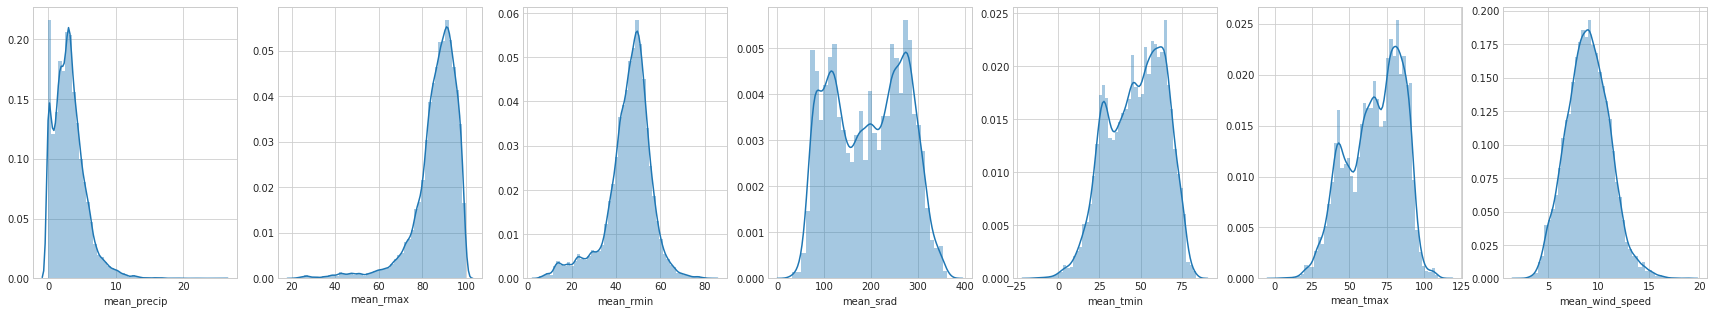

In [0]:
# Understand distribution of Variables
variables = weather_cbg_2019_month_sample.drop(["geoid","month"], axis = 1)
fig,ax = plt.subplots(1,7, figsize= (30,5))

for i, variable in enumerate(variables):
  sns.distplot(variables[variable], ax=ax[i])

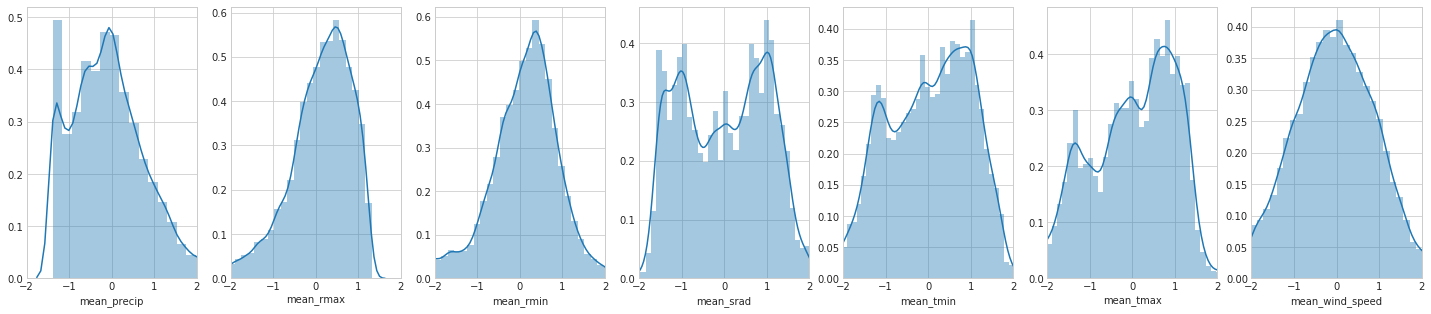

In [0]:
# these distributions are not on the same scale, standardize them
fix, ax = plt.subplots(1,7,figsize = (25,5))

for i, variable in enumerate(variables):
  original_variables = variables[variable]
  variable_scaled = (original_variables - original_variables.mean())/original_variables.std()
  sns.distplot(variable_scaled, ax=ax[i])
  ax[i].set_xlim(-2,2)

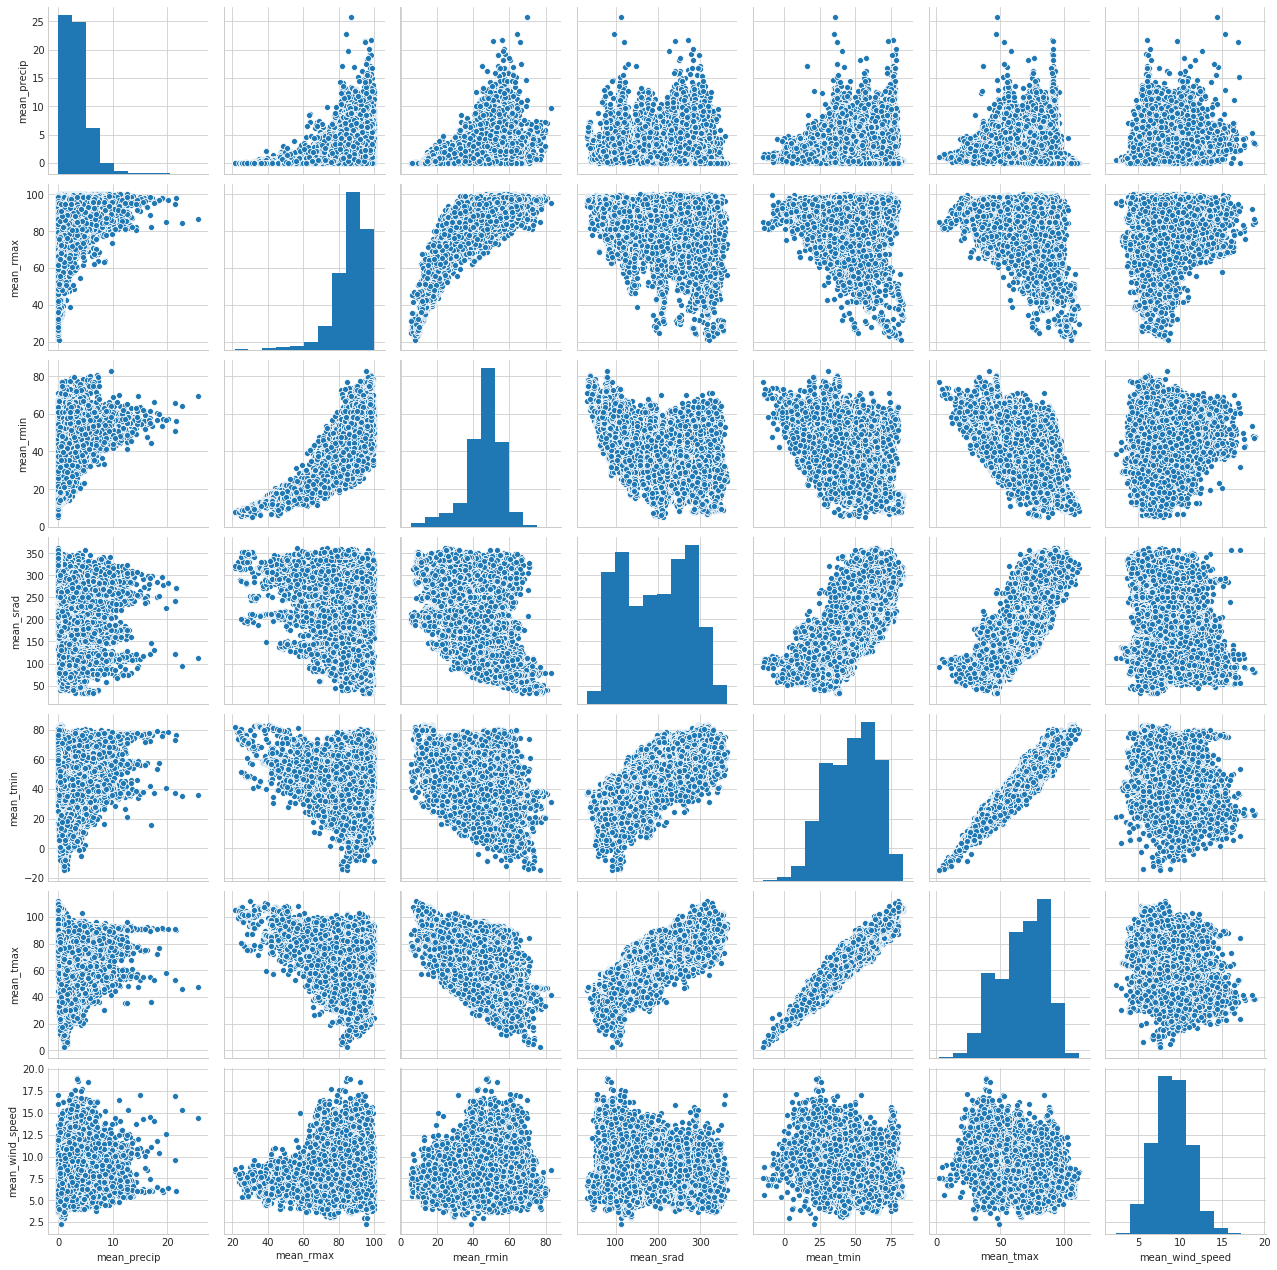

In [0]:
#correlation
g = sns.pairplot(variables)
g.fig.set_size_inches(15,10)

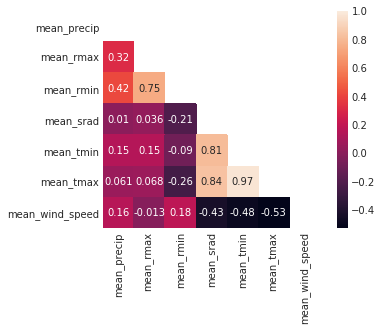

In [0]:
corr = variables.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask,0)] = True
sns.heatmap(corr, mask = mask,square = True, annot = True)

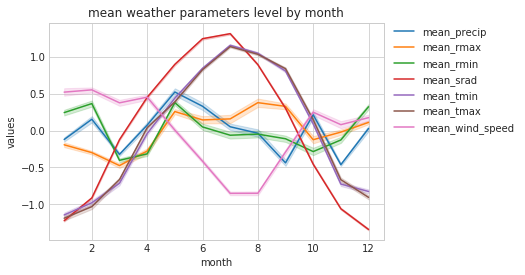

In [0]:
# # scaled data by month. This is generally the US case, it varies by the region
for i, variable in enumerate(variables):
  original_variables = variables[variable]
  variable_scaled = (original_variables - original_variables.mean())/original_variables.std()
  sns.lineplot(x = "month", y=variable_scaled, data = weather_cbg_2019_month_sample,legend='brief', label=variable)

plt.ylabel("values")
plt.legend(bbox_to_anchor=(1.02, 1),borderaxespad=0.)
plt.title("mean weather parameters level by month")


- Prepare Jan file for initial modeling

In [0]:
# Prepare Jan file for initial modeling
weatherDF_Jan = weathercbgDF.where(col("month") == 1).toPandas()
weatherDF_Jan.head(10)

,geoid,date,precip,rmax,rmin,srad,tmin,tmax,wind_speed,month,day,year
0,10730059033,2019-01-01,0.000,97.200,65.200,111.800,48.470,61.970,2.461,1,1,2019
1,10730059033,2019-01-02,20.900,86.300,81.600,30.600,48.470,52.790,3.355,1,2,2019
2,10730059033,2019-01-03,24.900,79.400,63.100,59.200,50.630,59.450,5.816,1,3,2019
3,10730059033,2019-01-04,0.900,100.000,55.700,99.100,40.550,62.150,14.316,1,4,2019
4,10730059033,2019-01-05,0.000,87.600,39.200,126.800,36.950,60.170,7.382,1,5,2019
5,10730059033,2019-01-06,0.000,95.800,33.200,119.400,36.770,66.830,2.908,1,6,2019
6,10730059033,2019-01-07,0.400,83.800,38.300,126.500,44.150,67.370,7.158,1,7,2019
7,10730059033,2019-01-08,0.000,100.000,43.900,116.400,42.710,68.990,8.948,1,8,2019
8,10730059033,2019-01-09,0.000,68.600,34.000,135.000,31.730,51.530,10.961,1,9,2019
9,10730059033,2019-01-10,0.000,60.100,31.100,133.500,27.410,45.590,8.053,1,10,2019


In [0]:
weatherDF_Jan.shape

Out[14]: (6680283, 12)

In [0]:
weatherDF_Jan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6680283 entries, 0 to 6680282
Data columns (total 12 columns):
 # Column Dtype 
--- ------ ----- 
 0 geoid int64 
 1 date object 
 2 precip float64
 3 rmax float64
 4 rmin float64
 5 srad float64
 6 tmin float64
 7 tmax float64
 8 wind_speed float64
 9 month int32 
 10 day int32 
 11 year int32 
dtypes: float64(7), int32(3), int64(1), object(1)
memory usage: 535.1+ MB

In [0]:
weatherDF_Jan.geoid.nunique()

Out[16]: 215493

In [0]:
weatherDF_Jan[weatherDF_Jan.geoid == 10730059033].head()

,geoid,date,precip,rmax,rmin,srad,tmin,tmax,wind_speed,month,day,year
0,10730059033,2019-01-01,0.000,97.200,65.200,111.800,48.470,61.970,2.461,1,1,2019
1,10730059033,2019-01-02,20.900,86.300,81.600,30.600,48.470,52.790,3.355,1,2,2019
2,10730059033,2019-01-03,24.900,79.400,63.100,59.200,50.630,59.450,5.816,1,3,2019
3,10730059033,2019-01-04,0.900,100.000,55.700,99.100,40.550,62.150,14.316,1,4,2019
4,10730059033,2019-01-05,0.000,87.600,39.200,126.800,36.950,60.170,7.382,1,5,2019


###### Step 2 : Data Preparation and Analysis for Social Distancing Metrics v2.1

- Get data from Safegraph
    - Download this dataset from safegraph through cluster terminal to filepath 'cd databricks/driver/mnt/' -> Move them to '/dbfs/mnt#'

In [0]:
# use this command to move files so that I can directly access from databricks data UI
dbutils.fs.mv(r"file:/mnt/", r"dbfs:/social_distance_data/", True)

In [0]:
%fs ls /social_distance_data/social_distance/2019/

path,name,size
dbfs:/social_distance_data/social_distance/2019/01/,01/,0
dbfs:/social_distance_data/social_distance/2019/02/,02/,0
dbfs:/social_distance_data/social_distance/2019/03/,03/,0
dbfs:/social_distance_data/social_distance/2019/04/,04/,0
dbfs:/social_distance_data/social_distance/2019/05/,05/,0
dbfs:/social_distance_data/social_distance/2019/06/,06/,0
dbfs:/social_distance_data/social_distance/2019/07/,07/,0
dbfs:/social_distance_data/social_distance/2019/08/,08/,0
dbfs:/social_distance_data/social_distance/2019/09/,09/,0
dbfs:/social_distance_data/social_distance/2019/10/,10/,0


In [0]:
%fs ls /social_distance_data/social_distance/2019/01

path,name,size
dbfs:/social_distance_data/social_distance/2019/01/01/,01/,0
dbfs:/social_distance_data/social_distance/2019/01/02/,02/,0
dbfs:/social_distance_data/social_distance/2019/01/03/,03/,0
dbfs:/social_distance_data/social_distance/2019/01/04/,04/,0
dbfs:/social_distance_data/social_distance/2019/01/05/,05/,0
dbfs:/social_distance_data/social_distance/2019/01/06/,06/,0
dbfs:/social_distance_data/social_distance/2019/01/07/,07/,0
dbfs:/social_distance_data/social_distance/2019/01/08/,08/,0
dbfs:/social_distance_data/social_distance/2019/01/09/,09/,0
dbfs:/social_distance_data/social_distance/2019/01/10/,10/,0


In [0]:
%fs ls /social_distance_data/social_distance/2019/01/01

path,name,size
dbfs:/social_distance_data/social_distance/2019/01/01/2019-01-01-social-distancing.csv.gz,2019-01-01-social-distancing.csv.gz,90505721


- Preparing SafeGraph social-distancing data
    - read one gzip file first to understand panda dataframe
    - read January data and prepare it for initial modeling, reason being that i wanna test the model out before scaling up the whole dataset
    - read all 2019 social-distancing dataset (approx 800M rows)

In [0]:
# use panda to read one file 
sd20190101 = pd.read_csv("/dbfs/social_distance_data/social_distance/2019/01/01/2019-01-01-social-distancing.csv.gz",compression = "gzip")
sd20190101.head() 

,origin_census_block_group,date_range_start,date_range_end,device_count,distance_traveled_from_home,bucketed_distance_traveled,median_dwell_at_bucketed_distance_traveled,completely_home_device_count,median_home_dwell_time,bucketed_home_dwell_time,at_home_by_each_hour,part_time_work_behavior_devices,full_time_work_behavior_devices,destination_cbgs,delivery_behavior_devices,median_non_home_dwell_time,candidate_device_count,bucketed_away_from_home_time,median_percentage_time_home,bucketed_percentage_time_home,mean_home_dwell_time,mean_non_home_dwell_time,mean_distance_traveled_from_home
0,10330210004,2019-01-01T00:00:00-06:00,2019-01-02T00:00:00-06:00,78,687,"{""16001-50000"":14,""0"":28,"">50000"":8,""2001-8000...","{""16001-50000"":38,"">50000"":207,""<1000"":52,""200...",28,714,"{""721-1080"":14,""361-720"":14,""61-360"":5,""<60"":1...","[42,44,45,46,46,45,42,44,44,41,48,39,37,33,30,...",7,1,"{""281419502003"":1,""010330210003"":5,""2401503010...",1,52,179,"{""21-45"":3,""481-540"":1,""541-600"":1,""46-60"":4,""...",92,"{""0-25"":17,""76-100"":51,""51-75"":5,""26-50"":1}",721,209,134263
1,10730049022,2019-01-01T00:00:00-06:00,2019-01-02T00:00:00-06:00,259,5381,"{""16001-50000"":12,""0"":94,"">50000"":58,""2001-800...","{""16001-50000"":165,"">50000"":177,""<1000"":129,""2...",93,58,"{""721-1080"":22,""361-720"":23,""61-360"":57,""<60"":...","[48,53,56,58,57,62,59,63,63,62,61,62,56,57,54,...",13,2,"{""121030273154"":1,""132150004003"":1,""0107301310...",1,44,1312,"{""21-45"":16,""481-540"":5,""541-600"":7,""46-60"":8,...",53,"{""0-25"":112,""76-100"":117,""51-75"":12,""26-50"":14}",292,221,76229
2,11210118001,2019-01-01T00:00:00-06:00,2019-01-02T00:00:00-06:00,91,1591,"{""16001-50000"":5,""0"":46,"">50000"":10,""2001-8000...","{""16001-50000"":84,"">50000"":247,""<1000"":181,""20...",45,487,"{""721-1080"":13,""361-720"":17,""61-360"":13,""<60"":...","[40,40,42,41,36,41,40,41,41,37,39,39,34,36,34,...",3,1,"{""011150405022"":2,""011210118002"":7,""0103796110...",1,0,299,"{""21-45"":3,""541-600"":1,""46-60"":1,""721-840"":1,""...",100,"{""0-25"":25,""76-100"":53,""51-75"":6,""26-50"":4}",588,181,15741
3,11250106021,2019-01-01T00:00:00-06:00,2019-01-02T00:00:00-06:00,392,4623,"{""16001-50000"":55,""0"":172,"">50000"":32,""2001-80...","{""16001-50000"":61,"">50000"":86,""<1000"":62,""2001...",171,860,"{""721-1080"":60,""361-720"":50,""61-360"":46,""<60"":...","[212,225,231,240,238,234,239,235,229,229,227,2...",26,8,"{""010730142031"":4,""010730141021"":2,""1313505054...",1,20,1059,"{""21-45"":26,""481-540"":2,""541-600"":7,""46-60"":14...",97,"{""0-25"":66,""76-100"":274,""51-75"":24,""26-50"":22}",770,172,12937
4,21880002003,2019-01-01T00:00:00-09:00,2019-01-02T00:00:00-09:00,10,0,"{""1-1000"":1,"">50000"":2,""0"":1}","{"">50000"":33,""<1000"":10}",3,1197,"{"">1080"":5,""<60"":1,""61-360"":1}","[1,3,4,3,7,4,5,5,6,4,6,6,4,7,7,5,5,3,8,1,6,8,5,5]",1,1,"{""021880002003"":6,""550790217005"":1,""0218800020...",1,10,36,"{""<20"":5,""601-660"":1,""361-420"":1,""841-960"":1}",99,"{""0-25"":4,""76-100"":5,""26-50"":1}",857,241,0


In [0]:
sd20190101.shape

Out[22]: (219490, 23)

In [0]:
sd20190101.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219490 entries, 0 to 219489
Data columns (total 23 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 origin_census_block_group 219490 non-null int64 
 1 date_range_start 219490 non-null object
 2 date_range_end 219490 non-null object
 3 device_count 219490 non-null int64 
 4 distance_traveled_from_home 219490 non-null int64 
 5 bucketed_distance_traveled 219490 non-null object
 6 median_dwell_at_bucketed_distance_traveled 219483 non-null object
 7 completely_home_device_count 219490 non-null int64 
 8 median_home_dwell_time 219490 non-null int64 
 9 bucketed_home_dwell_time 219490 non-null object
 10 at_home_by_each_hour 219490 non-null object
 11 part_time_work_behavior_devices 219490 non-null int64 
 12 full_time_work_behavior_devices 219490 non-null int64 
 13 destination_cbgs 219490 non-null object
 14 delivery_behavior_devices 219490 non-null int64 
 15 median_non_home_dwell_time 219490 non-null int64 
 16 candidate_device_count 219490 non-null int64 
 17 bucketed_away_from_home_time 219490 non-null object
 18 median_percentage_time_home 219490 non-null int64 
 19 bucketed_percentage_time_home 219490 non-null object
 20 mean_home_dwell_time 219490 non-null int64 
 21 mean_non_home_dwell_time 219490 non-null int64 
 22 mean_distance_traveled_from_home 219490 non-null int64 
dtypes: int64(14), object(9)
memory usage: 38.5+ MB

- Initial Modeling for Jan data only - Part 1
   - Prepare Jan social distancing dataset

In [0]:
# Prepare January file for initial modeling
Jan_files = glob.glob("/dbfs/social_distance_data/social_distance/2019/01/*/*")

li= []
for file in Jan_files:
    df = pd.read_csv(file, compression='gzip', usecols=['origin_census_block_group','date_range_start','date_range_end','distance_traveled_from_home','mean_home_dwell_time','completely_home_device_count','device_count'])
    li.append(df)

sd_data_jan = pd.concat(li, axis=0, ignore_index=True)
del li
sd_data_jan.head(10)

,origin_census_block_group,date_range_start,date_range_end,device_count,distance_traveled_from_home,completely_home_device_count,mean_home_dwell_time
0,10330210004,2019-01-01T00:00:00-06:00,2019-01-02T00:00:00-06:00,78,687,28,721
1,10730049022,2019-01-01T00:00:00-06:00,2019-01-02T00:00:00-06:00,259,5381,93,292
2,11210118001,2019-01-01T00:00:00-06:00,2019-01-02T00:00:00-06:00,91,1591,45,588
3,11250106021,2019-01-01T00:00:00-06:00,2019-01-02T00:00:00-06:00,392,4623,171,770
4,21880002003,2019-01-01T00:00:00-09:00,2019-01-02T00:00:00-09:00,10,0,3,857
5,40019450014,2019-01-01T00:00:00-07:00,2019-01-02T00:00:00-07:00,97,615,33,204
6,40130101023,2019-01-01T00:00:00-07:00,2019-01-02T00:00:00-07:00,135,3635,47,687
7,40132175012,2019-01-01T00:00:00-07:00,2019-01-02T00:00:00-07:00,79,1205,55,799
8,40136145004,2019-01-01T00:00:00-07:00,2019-01-02T00:00:00-07:00,89,1435,28,802
9,40136170001,2019-01-01T00:00:00-07:00,2019-01-02T00:00:00-07:00,59,2557,23,821


In [0]:
sd_data_jan['date_range_start'] = pd.to_datetime(sd_data_jan['date_range_start'],utc= True)
sd_data_jan['date_range_end'] = pd.to_datetime(sd_data_jan['date_range_end'],utc= True)
sd_data_jan['month'] = sd_data_jan['date_range_start'].dt.month
sd_data_jan['day'] = sd_data_jan['date_range_start'].dt.day
sd_data_jan['dayofweek'] = sd_data_jan['date_range_start'].dt.dayofweek
sd_data_jan['date_time'] = sd_data_jan['date_range_end']-sd_data_jan['date_range_start']
# sd_data_jan['date'] = [d.date() for d in sd_data_jan['date_range_start']]
sd_data_jan['ratio_not_leaving'] = round(sd_data_jan['completely_home_device_count']/sd_data_jan['device_count'],4)
sd_data_jan = sd_data_jan.drop(['date_range_start','date_range_end'],1)

# sd_data_jan.to_csv("/dbfs/social_distance_data/jan.csv",index= False)  # save it for next time use

In [0]:
sd_data_jan = pd.read_csv("/dbfs/social_distance_data/jan.csv")
sd_data_jan.head()

,origin_census_block_group,device_count,distance_traveled_from_home,completely_home_device_count,mean_home_dwell_time,month,day,dayofweek,date_time,ratio_not_leaving
0,10330210004,78,687,28,721,1,1,1,1 days 00:00:00.000000000,0.359
1,10730049022,259,5381,93,292,1,1,1,1 days 00:00:00.000000000,0.359
2,11210118001,91,1591,45,588,1,1,1,1 days 00:00:00.000000000,0.494
3,11250106021,392,4623,171,770,1,1,1,1 days 00:00:00.000000000,0.436
4,21880002003,10,0,3,857,1,1,1,1 days 00:00:00.000000000,0.300


In [0]:
sd_data_jan.shape

Out[47]: (6805915, 10)

In [0]:
sd_data_jan[sd_data_jan.date_time > '1 days 00:00:00']

,origin_census_block_group,device_count,distance_traveled_from_home,completely_home_device_count,mean_home_dwell_time,month,day,dayofweek,date_time,ratio_not_leaving
4297985,21989401001,20,0,15,954,1,20,6,1 days 01:00:00,0.750
4315583,21989401002,61,155,33,817,1,20,6,1 days 01:00:00,0.541
4328180,21989401003,6,272,1,654,1,20,6,1 days 01:00:00,0.167


In [0]:
sd_data_jan.origin_census_block_group.nunique()  # 219759
sd_data_jan.origin_census_block_group[~sd_data_jan.origin_census_block_group.isin(weatherDF_Jan.geoid)].nunique() # 4869

Out[58]: 4869

- Initial Modeling for Jan data only - Part 2
   - Join Jan weather and Jan social distancing dataset together

In [0]:
# sd_data_jan = pd.read_csv("./social_distance_data/jan.csv")
merge_Jan = pd.merge(sd_data_jan.drop('date_time',1), weatherDF_Jan, how='inner', left_on=['origin_census_block_group','day','month'], right_on = ['geoid','day','month'])

In [0]:
merge_Jan.head()

,origin_census_block_group,device_count,distance_traveled_from_home,completely_home_device_count,mean_home_dwell_time,month,day,dayofweek,ratio_not_leaving,geoid,date,precip,rmax,rmin,srad,tmin,tmax,wind_speed,year
0,10330210004,78,687,28,721,1,1,1,0.359,10330210004,2019-01-01,0.400,99.900,67.600,110.300,43.430,56.390,6.263,2019
1,10730049022,259,5381,93,292,1,1,1,0.359,10730049022,2019-01-01,0.000,94.700,66.500,111.900,50.270,62.510,2.908,2019
2,11210118001,91,1591,45,588,1,1,1,0.494,11210118001,2019-01-01,0.000,98.200,64.300,99.600,49.370,63.770,2.908,2019
3,11250106021,392,4623,171,770,1,1,1,0.436,11250106021,2019-01-01,0.000,94.800,65.800,117.700,50.090,63.050,4.026,2019
4,40019450014,97,615,33,204,1,1,1,0.340,40019450014,2019-01-01,0.600,100.000,69.300,87.000,-3.730,25.790,3.803,2019


In [0]:
merge_Jan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6656671 entries, 0 to 6656670
Data columns (total 19 columns):
 # Column Dtype 
--- ------ ----- 
 0 origin_census_block_group int64 
 1 device_count int64 
 2 distance_traveled_from_home int64 
 3 completely_home_device_count int64 
 4 mean_home_dwell_time int64 
 5 month int64 
 6 day int64 
 7 dayofweek int64 
 8 ratio_not_leaving float64
 9 geoid int64 
 10 date object 
 11 precip float64
 12 rmax float64
 13 rmin float64
 14 srad float64
 15 tmin float64
 16 tmax float64
 17 wind_speed float64
 18 year int32 
dtypes: float64(8), int32(1), int64(9), object(1)
memory usage: 990.3+ MB

In [0]:
merge_Jan[merge_Jan.geoid==10730059033].head()

,origin_census_block_group,device_count,distance_traveled_from_home,completely_home_device_count,mean_home_dwell_time,month,day,dayofweek,ratio_not_leaving,geoid,date,precip,rmax,rmin,srad,tmin,tmax,wind_speed,year
119438,10730059033,159,2770,76,693,1,1,1,0.478,10730059033,2019-01-01,0.000,97.200,65.200,111.800,48.470,61.970,2.461,2019
316193,10730059033,160,4737,66,689,1,2,2,0.412,10730059033,2019-01-02,20.900,86.300,81.600,30.600,48.470,52.790,3.355,2019
536561,10730059033,172,2594,65,614,1,3,3,0.378,10730059033,2019-01-03,24.900,79.400,63.100,59.200,50.630,59.450,5.816,2019
783345,10730059033,164,3202,50,598,1,4,4,0.305,10730059033,2019-01-04,0.900,100.000,55.700,99.100,40.550,62.150,14.316,2019
978619,10730059033,153,3017,64,680,1,5,5,0.418,10730059033,2019-01-05,0.000,87.600,39.200,126.800,36.950,60.170,7.382,2019


In [0]:
merge_Jan.describe()

,origin_census_block_group,device_count,distance_traveled_from_home,completely_home_device_count,mean_home_dwell_time,month,day,dayofweek,ratio_not_leaving,geoid,precip,rmax,rmin,srad,tmin,tmax,wind_speed,year
count,6656671.000,6656671.000,6656671.000,6656671.000,6656671.000,6656671.000,6656671.000,6656671.000,6656671.000,6656671.000,6656671.000,6656671.000,6656671.000,6656671.000,6656671.000,6656671.000,6656671.000,6656671.000
mean,282385292411.453,104.902,3042.528,38.779,670.554,1.000,16.000,2.903,0.368,282385292411.453,2.878,84.209,47.893,98.880,27.564,45.480,10.121,2019.000
std,157037390478.091,104.110,14088.512,47.029,110.943,0.000,8.944,1.940,0.108,157037390478.091,7.425,16.064,16.459,38.812,16.418,17.339,4.820,0.000
min,10010201001.000,5.000,0.000,1.000,0.000,1.000,1.000,0.000,0.003,10010201001.000,0.000,21.400,1.100,13.600,-45.850,-24.790,0.671,2019.000
25%,131210002002.000,55.000,1280.000,19.000,609.000,1.000,8.000,1.000,0.293,131210002002.000,0.000,74.200,36.000,69.200,18.950,33.530,6.487,2019.000
50%,281079501001.000,80.000,2097.000,29.000,675.000,1.000,16.000,3.000,0.367,281079501001.000,0.000,87.700,47.300,98.200,28.670,45.770,9.171,2019.000
75%,410510025012.000,122.000,3292.000,46.000,740.000,1.000,24.000,5.000,0.441,410510025012.000,1.400,100.000,60.100,126.100,38.750,58.910,12.974,2019.000
max,560459513003.000,37862.000,4260755.000,34014.000,1393.000,1.000,31.000,6.000,0.949,560459513003.000,223.800,100.000,100.000,247.000,77.810,88.250,42.502,2019.000


In [0]:
# no missing value
merge_Jan.isna().sum()

Out[26]: origin_census_block_group 0
device_count 0
distance_traveled_from_home 0
completely_home_device_count 0
mean_home_dwell_time 0
month 0
day 0
dayofweek 0
ratio_not_leaving 0
geoid 0
date 0
precip 0
rmax 0
rmin 0
srad 0
tmin 0
tmax 0
wind_speed 0
year 0
dtype: int64

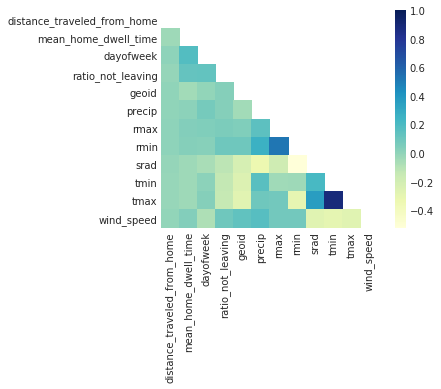

In [0]:
corr = merge_Jan.iloc[:,np.r_[2,4,7:18]].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask,0)] = True
print('Correlation Matrix : ')
sns.heatmap(corr, mask = mask,square = True, annot = False , cmap="YlGnBu")

/

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10,10)

- Initial Modeling for Jan data only - Part 3
   - Response Visualization - 1
     - distance_traveled_from_home -  highly skewed

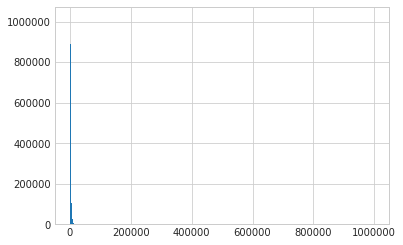

In [0]:
# # understand predictor  = distance traveled, highly right skewed
plt.hist(merge_Jan.distance_traveled_from_home, bins = range(0, 1000000,500))
plt.show()

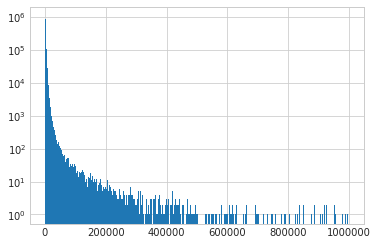

In [0]:
# # understand predictor  = distance traveled, highly right skewed
plt.hist(merge_Jan.distance_traveled_from_home, bins = range(0, 1000000,500), log = True)
plt.show()

In [0]:
merge_Jan.distance_traveled_from_home[merge_Jan.distance_traveled_from_home > 500000].count() # 803
merge_Jan.distance_traveled_from_home[merge_Jan.distance_traveled_from_home > 100000].count() #5133
# how many 0 distance, this is important for later transformation, 18743 , not significant
merge_Jan.distance_traveled_from_home[merge_Jan.distance_traveled_from_home == 0].count()  # 18743
merge_Jan.distance_traveled_from_home[merge_Jan.distance_traveled_from_home > 10000].count() / merge_Jan.distance_traveled_from_home.count()

Out[11]: 0.022128328108749856

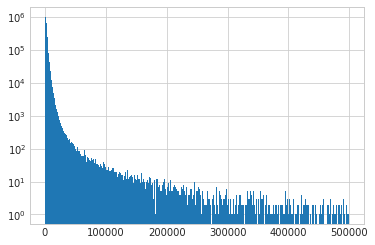

In [0]:
# Try a cut off of 50000 meters
plt.hist(merge_Jan.distance_traveled_from_home, bins = range(0, 500000,500), log = True)
plt.show()

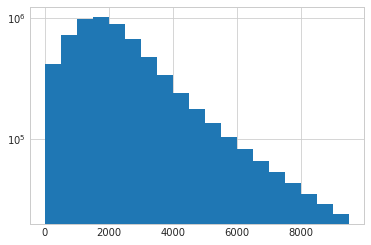

In [0]:
# Try a cut off of 10000 meters
plt.hist(merge_Jan.distance_traveled_from_home, bins = range(0, 10000,500), log = True)
plt.show()

In [0]:
merge_Jan.columns

Out[15]: Index(['origin_census_block_group', 'device_count',
 'distance_traveled_from_home', 'completely_home_device_count',
 'mean_home_dwell_time', 'month', 'day', 'dayofweek',
 'ratio_not_leaving', 'geoid', 'date', 'precip', 'rmax', 'rmin', 'srad',
 'tmin', 'tmax', 'wind_speed', 'year'],
 dtype='object')

- Initial Modeling for Jan data only - Part 3
   - Response Visualization 2
     - mean_home_dwell_home

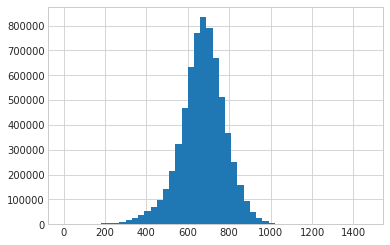

In [0]:
plt.hist(merge_Jan.mean_home_dwell_time, bins = range(0, 1500,30))
plt.show()# 

- Initial Modeling for Jan data only - Part 3
   - Response Visualization 3
     - ratio of not leaving

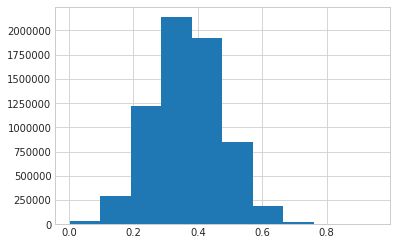

In [0]:
plt.hist(merge_Jan.ratio_not_leaving)
plt.show()# 

- Initial Modeling for Jan data only - Part 4
   - Data Preposessing

In [0]:
# merge_Jan_v1 = merge_Jan.iloc[:,[2,11,12,13,14,15,16,17]]
merge_Jan_v1 = merge_Jan[merge_Jan.columns[2,11,12:18]]t
merge_Jan_v1 = merge_Jan.iloc[:,np.r_[2,11,12:18]]
merge_Jan_v1[merge_Jan_v1.tmin<0].count() # 421488, around 6%


merge_Jan_v1['tmin'] = merge_Jan_v1['tmin']+46
merge_Jan_v1['tmax'] = merge_Jan_v1['tmax']+46

def bottom_out(x):
  if x < 1:
    return 1
  return x

merge_Jan_v1['distance_traveled_from_home'] = merge_Jan_v1['distance_traveled_from_home'].map(bottom_out)
merge_Jan_v1['precip'] = merge_Jan_v1['precip'].map(bottom_out)

merge_Jan_v1.describe()

,distance_traveled_from_home,precip,rmax,rmin,srad,tmin,tmax,wind_speed
count,6656671.000,6656671.000,6656671.000,6656671.000,6656671.000,6656671.000,6656671.000,6656671.000
mean,3042.530,3.568,84.209,47.893,98.880,73.564,91.480,10.121
std,14088.511,7.169,16.064,16.459,38.812,16.418,17.339,4.820
min,1.000,1.000,21.400,1.100,13.600,0.150,21.210,0.671
25%,1280.000,1.000,74.200,36.000,69.200,64.950,79.530,6.487
50%,2097.000,1.000,87.700,47.300,98.200,74.670,91.770,9.171
75%,3292.000,1.400,100.000,60.100,126.100,84.750,104.910,12.974
max,4260755.000,223.800,100.000,100.000,247.000,123.810,134.250,42.502


- Initial Modeling for Jan data only - Part 5
   - Visualization of response(mean_distance_traveled_from_home) with features
     - this response variable is not optimal

In [0]:
merge_Jan_1 = merge_Jan[merge_Jan.distance_traveled_from_home < 500000]

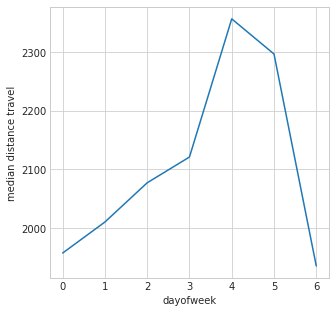

In [0]:
# take a sample for visualization
merge_Jan_1_sample = merge_Jan_1.sample(frac=0.05)

fig, ax = plt.subplots(figsize=(5,5))
merge_Jan_1_sample.groupby(['dayofweek']).median()['distance_traveled_from_home'].plot(ax=ax)
plt.ylabel('median distance travel')


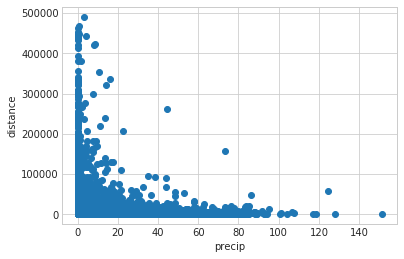

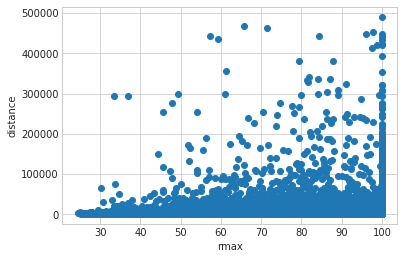

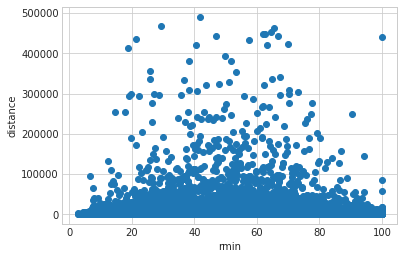

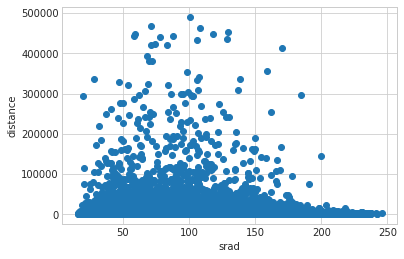

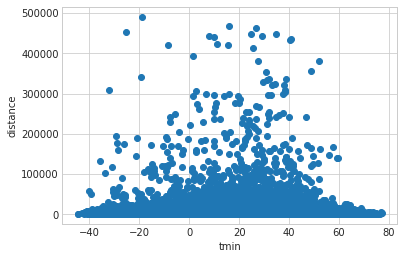

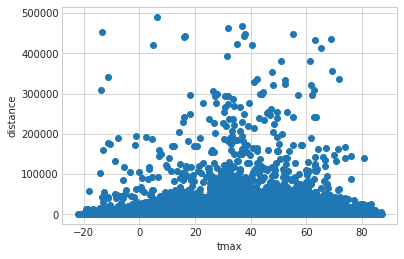

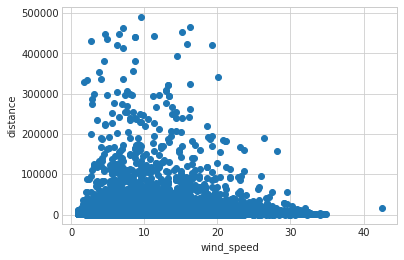

In [0]:
# relationship between distance and exploratory variables

for x in merge_Jan_1_sample.columns[11:18]:
  plt.scatter(x=x, y='distance_traveled_from_home', data=merge_Jan_1_sample)
  plt.xlabel(x)
  plt.ylabel('distance')
  plt.show()


In [0]:
merge_Jan_2 = merge_Jan[merge_Jan.distance_traveled_from_home < 10000]

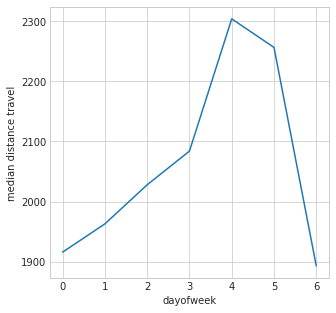

In [0]:
# take a sample for visualization
merge_Jan_2_sample = merge_Jan_2.sample(frac=0.05)

fig, ax = plt.subplots(figsize=(5,5))
merge_Jan_2_sample.groupby(['dayofweek']).median()['distance_traveled_from_home'].plot(ax=ax)
plt.ylabel('median distance travel')


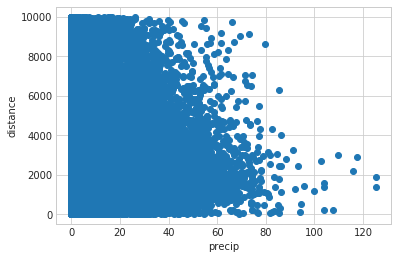

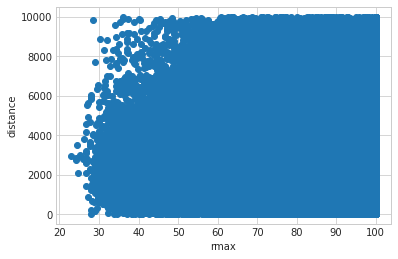

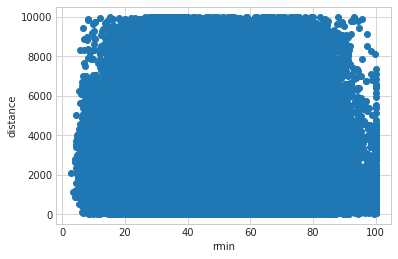

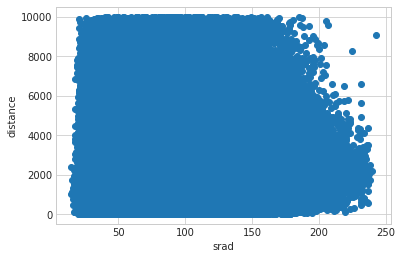

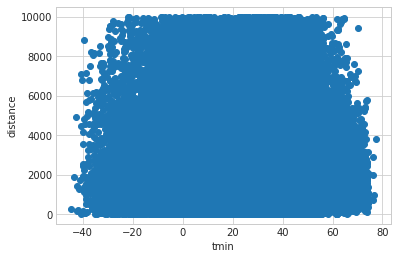

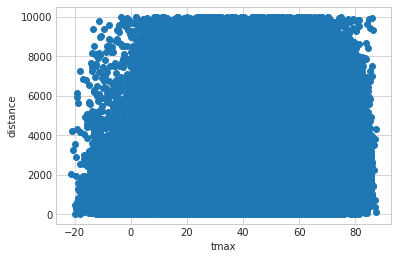

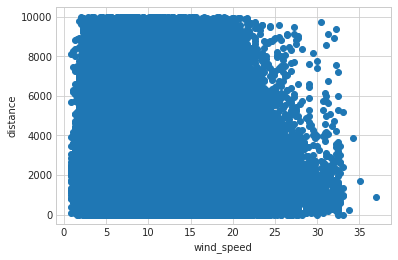

In [0]:
# relationship between distance and exploratory variables

for x in merge_Jan_2_sample.columns[11:18]:
  plt.scatter(x=x, y='distance_traveled_from_home', data=merge_Jan_2_sample)
  plt.xlabel(x)
  plt.ylabel('distance')
  plt.show()


- Initial Modeling for Jan data only - Part 5
   - Visualization of response(mean_home_dwell_time) with features

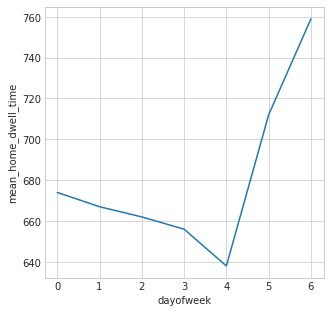

In [0]:
# take a sample for visualization
merge_Jan_3_sample = merge_Jan.sample(frac=0.05)

fig, ax = plt.subplots(figsize=(5,5))
merge_Jan_3_sample.groupby(['dayofweek']).median()['mean_home_dwell_time'].plot(ax=ax)
plt.ylabel('mean_home_dwell_time')

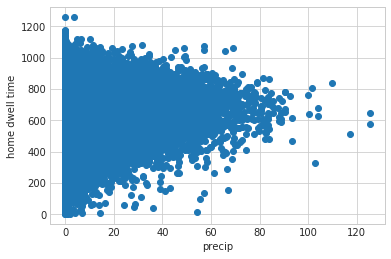

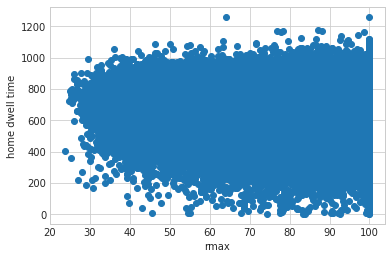

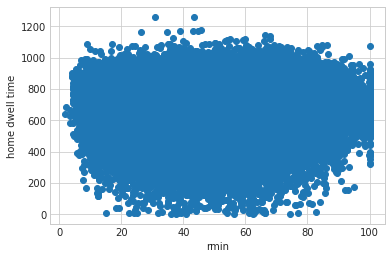

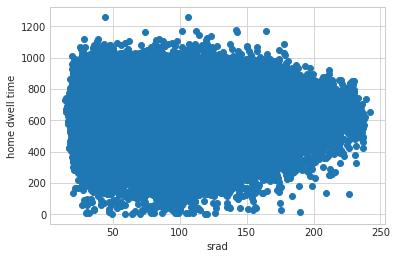

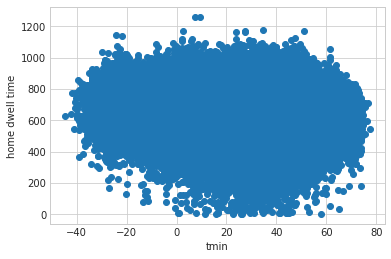

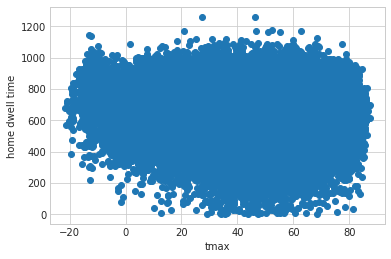

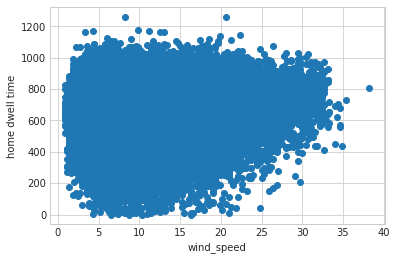

In [0]:
# relationship between distance and exploratory variables

for x in merge_Jan_3_sample.columns[11:18]:
  plt.scatter(x=x, y='mean_home_dwell_time', data=merge_Jan_3_sample)
  plt.xlabel(x)
  plt.ylabel('home dwell time')
  plt.show()

- Initial Modeling for Jan data only - Part 5
   - Visualization of response(ratio of not leaving) with features

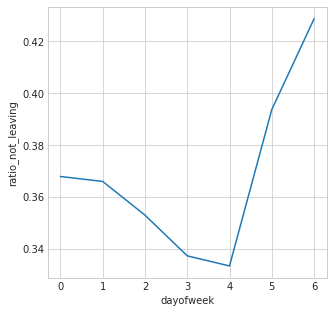

In [0]:
# take a sample for visualization
fig, ax = plt.subplots(figsize=(5,5))
merge_Jan_3_sample.groupby(['dayofweek']).median()['ratio_not_leaving'].plot(ax=ax)
plt.ylabel('ratio_not_leaving')

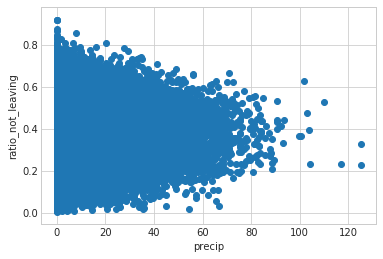

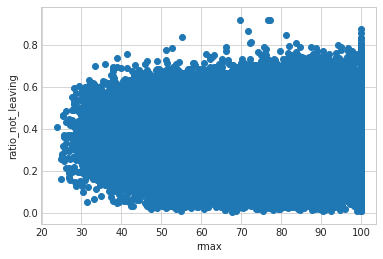

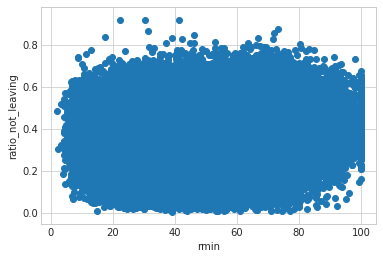

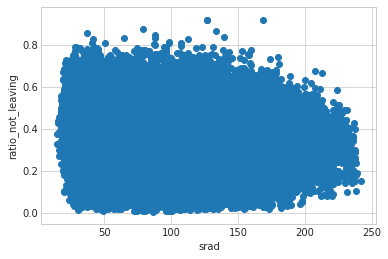

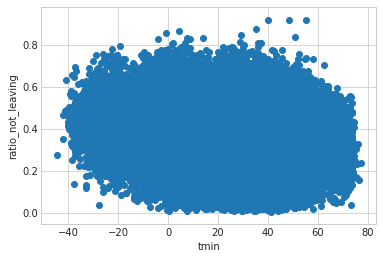

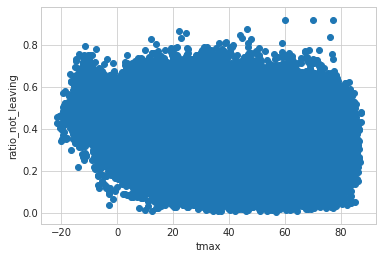

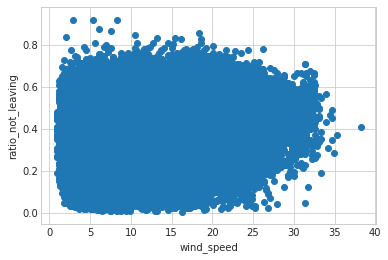

In [0]:
# relationship between distance and exploratory variables

for x in merge_Jan_3_sample.columns[11:18]:
  plt.scatter(x=x, y='ratio_not_leaving', data=merge_Jan_3_sample)
  plt.xlabel(x)
  plt.ylabel('ratio_not_leaving')
  plt.show()

- Initial Modeling for Jan data only - Part 6
   - Feature Engineering

In [0]:
y = merge_Jan_1['distance_traveled_from_home']

def bottom_out(x):
  if x < 1:
    return 1
  return x

y = y.map(bottom_out)
# y = y.apply(lamda x : 1 for x<1 else x)
y = stats.boxcox(y)[0]

sns.distplot(y)

In [0]:
# # lasso will drop the correlated variables, so we don't need to worry about it

from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer


X = merge_Jan_1.iloc[:,np.r_[11:18,7]]
enc_col = X.columns[-1]
scal_col = X.columns[:-1]

encoded_X = pd.get_dummies(X.dayofweek)

scaler = StandardScaler()
# Scale, Lasso assumes Gaussian distribution
for i in scal_col:
  X.loc[:,i] = scaler.fit_transform(X[[i]])

X = np.concatenate([X.drop('dayofweek',1), encoded_X], axis=1)
X.shape 

Out[86]: (6655868, 14)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

In [0]:
# how to take care of this, like the scale, how many distance do we want cuz the accuracy score is so low

from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

clf = linear_model.Ridge()

grid = GridSearchCV(estimator=clf, param_grid=dict(alpha=np.array([1,0.1,0.01,0.001,0.0001,0])))
grid.fit(X_train, y_train)
print(grid)
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_.alpha)

GridSearchCV(cv=None, error_score=nan,
 estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
 max_iter=None, normalize=False, random_state=None,
 solver='auto', tol=0.001),
 iid='deprecated', n_jobs=None,
 param_grid={'alpha': array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04, 0.e+00])},
 pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
 scoring=None, verbose=0)
0.015371926867061658
0.0

In [0]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


# param_grid = {   'n_estimators': [105, 120,150],
#                  'max_depth': [45, 50, 55]
#              }

# rf = RandomForestRegressor(random_state=2, max_features = 'sqrt', verbose = 3)
# grid_rf = GridSearchCV(rf, param_grid, cv=5)
# grid_rf.fit(X_train, y_train)

# rf = RandomForestRegressor(random_state=2, max_features = 'sqrt', verbose = 3)
# rf.fit(X_train, y_train)

Error while obtaining a new communication channel